In [1]:
from pydub import AudioSegment
from pydub.utils import mediainfo
from scipy import spatial
from glob import glob
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import h5py
import datetime
%matplotlib inline

In [2]:
f = h5py.File("test.hdf5", "r")

In [3]:
list(f)

['135043', '135054', '135091', '135336', '135337']

In [32]:
templabel = '135043'
NUM_FP = f[templabel].shape[0]
LENGTH = f[templabel].shape[1]
PER_MUSIC = 13
NUM_LABEL = 5
ANCHOR_LEN = 13
NUM_MUSIC = 5

def get_batch(f, k=64, shuffle=True, actual_label=False):
    ##f: hdf5 file object
    
    # initialize array
    batch = []
    label = []

    # get the anchor label
    anchor = np.random.choice(NUM_MUSIC, 1)[0]
    
    # get different negative labels
    labels = np.random.choice(NUM_MUSIC, NUM_LABEL-ANCHOR_LEN//PER_MUSIC, replace=False)
    while np.any(labels == anchor):
        labels = np.random.choice(NUM_MUSIC, NUM_LABEL-ANCHOR_LEN//PER_MUSIC, replace=False)
    
    # get 8 positive data (consecutive segments within 400 ms)
    cur_label = list(f)[anchor]
    num_fp = f[cur_label].shape[0]
    start = np.random.choice(num_fp-ANCHOR_LEN, 1)[0] # get start point of the segments
    batch.append(f[cur_label][start:start+ANCHOR_LEN])
    #batch.append(f[cur_label][start+ANCHOR_LEN//2:start+ANCHOR_LEN])
    if actual_label:
        label += [int(cur_label)] * ANCHOR_LEN
    else:
        label += [0] * ANCHOR_LEN

    # get negative data
    for i in range(len(labels)):
        cur_label = list(f)[labels[i]]
        num_fp = f[cur_label].shape[0]
        rand = np.sort(np.random.choice(num_fp, PER_MUSIC, replace=False))
        val = f[cur_label][list(rand)]
        batch.append(val)
        
        if actual_label:
            label += [int(cur_label)] * PER_MUSIC
        else:
            label += list(np.arange(PER_MUSIC)+i*PER_MUSIC)

    batch = np.asarray(batch)
    batch = batch.reshape(PER_MUSIC*NUM_LABEL, LENGTH)
    label = np.asarray(label)

    # shuffle all samples
    if shuffle:
        s = np.arange(batch.shape[0])
        np.random.shuffle(s)
        batch = batch[s]
        label = label[s]
    
    # create k-size batches
    batch = batch[:k]
    label = label[:k]
    batch = batch.reshape(k, LENGTH, 1)

    return np.asarray(batch), np.asarray(label)

In [5]:
start = datetime.datetime.now()
train_data, train_label = get_batch(f)
end = datetime.datetime.now()
print(train_label.shape)
print(end-start)

(64,)
0:00:00.150722


In [6]:
np.amin(train_data)

-1.0000305

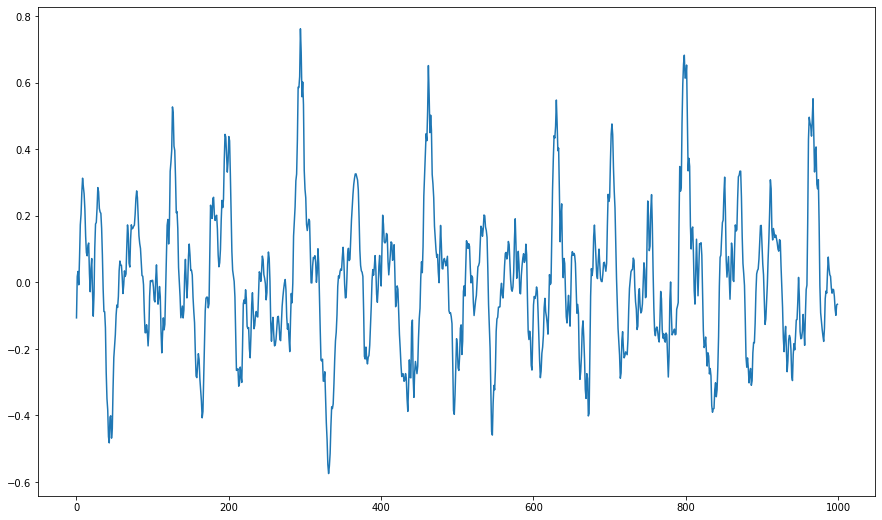

In [7]:
plt.figure(figsize=(15,9))
plt.plot(train_data[0][:1000])

In [8]:
MARGIN = 0.2

"""Define functions to create the triplet loss with online triplet mining."""

def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    We generate all the valid triplets and average the loss over the positive ones.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets


def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

In [9]:
NUM_EMBEDDING = 16
SPLIT = 8

def model(features):
    # convolution layer 1 
    conv1 = tf.layers.conv1d(
        inputs=features,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 1
    pool1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2)
    
    # convolution layer 2 
    conv2 = tf.layers.conv1d(
        inputs=pool1,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 2
    pool2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2)
    
    # convolution layer 3 
    conv3 = tf.layers.conv1d(
        inputs=pool2,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 3
    pool3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2)
    
    # flatten input: 16*64=1024
    flat = tf.layers.flatten(pool3)
    
    drop = tf.layers.dropout(flat)

    # divide and encode
    concatenate = []
    num_each_split = drop.shape[-1]//SPLIT
    units = NUM_EMBEDDING//SPLIT
    splits = tf.split(drop, SPLIT, 1)

    divides = []
    for i in range(SPLIT):
        divide = tf.layers.dense(splits[i], activation=tf.nn.relu, units=128)
        divide = tf.layers.dense(divide, units=units)
        concatenate.append(divide)
        divides.append(divide)
    
    embedding = tf.concat([elem for elem in concatenate], 1)

    return embedding

In [10]:
NUM_EMBEDDING = 16
NUM_LAYERS = 6

def model2(features):
    pool = []
    
    for i in range(NUM_LAYERS):
        if len(pool) == 0:
            inputs = features
        else:
            inputs = pool[-1]
            
        # convolution layers
        conv = tf.layers.conv1d(
            inputs=inputs,
            filters=32,
            kernel_size=3,
            padding="same",
            activation=tf.nn.relu)

        # pooling layers
        pool.append(tf.layers.max_pooling1d(inputs=conv, pool_size=2, strides=2))
        print(pool[-1])
    
    flat = tf.layers.flatten(pool[-1])
    print(flat)
    dense1 = tf.layers.dense(flat, activation=tf.nn.relu, units=1024)
    dense2 = tf.layers.dense(dense1, activation=tf.nn.relu, units=128)
    embedding = tf.layers.dense(dense1, units=NUM_EMBEDDING)
    
    return embedding

In [11]:
tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [None, LENGTH, 1])
input_label = tf.placeholder(tf.int32, [None])

# loss function operations
embedded = model2(input_data)
#embedded = tf.debugging.check_numerics(embedded, 'embedded data has nan!')
#dists = dist(embedded, embedded)
loss, _dis = batch_all_triplet_loss(input_label, embedded, MARGIN, squared=True)
#loss = tf.reduce_mean(triplet_l)

# train operation
optimizer = tf.train.AdamOptimizer(learning_rate=0.00001)
#variables = tf.trainable_variables()
#gradients = optimizer.compute_gradients(loss, variables)
train_op = optimizer.minimize(
    loss=loss,
    global_step=tf.train.get_global_step())
init = tf.global_variables_initializer()

W0722 16:09:10.402369 4566607296 deprecation.py:323] From <ipython-input-10-eae428a4f636>:19: conv1d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
W0722 16:09:10.408954 4566607296 deprecation.py:323] From /Users/wjr/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/layers/convolutional.py:218: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
W0722 16:09:10.469515 4566607296 deprecation.py:323] From <ipython-input-10-eae428a4f636>:22: max_pooling1d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling1D instead.
W0722 16:09:10.618479 4566607296 deprecation.py:323] From <ipython-input-10-eae428a4f636>:25: flatten (from tensorflow

Tensor("max_pooling1d/Squeeze:0", shape=(?, 33075, 32), dtype=float32)
Tensor("max_pooling1d_1/Squeeze:0", shape=(?, 16537, 32), dtype=float32)
Tensor("max_pooling1d_2/Squeeze:0", shape=(?, 8268, 32), dtype=float32)
Tensor("max_pooling1d_3/Squeeze:0", shape=(?, 4134, 32), dtype=float32)
Tensor("max_pooling1d_4/Squeeze:0", shape=(?, 2067, 32), dtype=float32)
Tensor("max_pooling1d_5/Squeeze:0", shape=(?, 1033, 32), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 33056), dtype=float32)


W0722 16:09:10.755976 4566607296 deprecation.py:323] From <ipython-input-8-0a8e51ed38d3>:144: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0722 16:09:10.941702 4566607296 deprecation.py:323] From /Users/wjr/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
num_epoch = 10
saver = tf.train.Saver()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)
loss_hist = []
saver.restore(sess, "../model/16_batch")

W0722 16:11:18.456914 4566607296 deprecation.py:323] From /Users/wjr/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/training/saver.py:1279: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [15]:
start = datetime.datetime.now()
for i in range(num_epoch):
    train_data, train_label = get_batch(f)
    _, loss_val, embedding = sess.run([train_op, loss, embedded],
                           feed_dict={input_data: train_data,
                                      input_label: train_label})
    loss_hist.append(loss_val)
    if i % 2 == 0:
        print('iter num: '+str(i)+' loss: '+str(loss_hist[-1]))
    #print('embedding: '+str(embedding))
end = datetime.datetime.now()
print('time: '+str(end-start))

iter num: 0 loss: 0.16105357
iter num: 2 loss: 0.12212352
iter num: 4 loss: 0.1583558
iter num: 6 loss: 0.15414998
iter num: 8 loss: 0.13683704
time: 0:01:54.693558


In [16]:
saver = tf.train.Saver()
save_path = saver.save(sess, "../model/16_batch")
print("Model saved in path: %s" % save_path)

Model saved in path: ../model/16_batch


first five embeddings: [-0.39420074  0.22609715 -0.53500056  0.12751503 -0.07932526 -0.1137429
 -0.03722929 -0.0858273  -0.39114535 -0.06165478 -0.10534278 -0.25937533
 -0.12942553  0.01500273  0.01400941  0.21816894]

first ten labels: [26 44 36  6  4 21 40 38 39 31 49  0  2 18  8 24 11  5  7 19  0  9  0  0
 27 12 23 34 22  0 25  0 41  0  3  0  0 16 51 50 42 37 13 47  0 14 10 28
  0 33  0  1 15 32 30 43 48 35 45 17 20  0 29  0]


Text(0.5, 1.0, 'loss history')

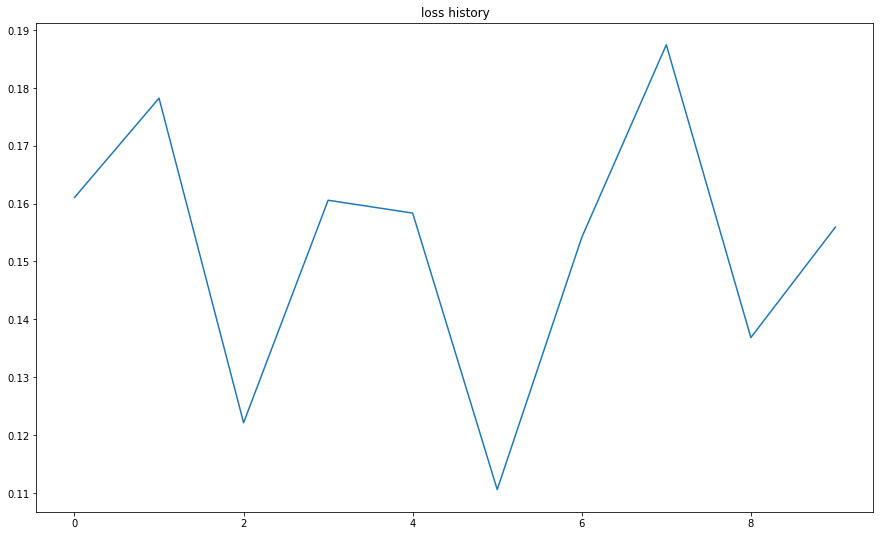

In [17]:
train_data, train_label = get_batch(f)
embeddings = sess.run([embedded], feed_dict={input_data: train_data})
print('first five embeddings: '+str(embeddings[0][0]))
print('\nfirst ten labels: '+str(train_label))
plt.figure(figsize=(15,9))
plt.plot(loss_hist)
plt.title('loss history')

In [18]:
tvars = tf.trainable_variables()
tvars_vals = sess.run(tvars)
#for var, val in zip(tvars, tvars_vals):
    #print(var.name, val) 
    
#tvars = tf.trainable_variables()
#for var, grads in zip(tvars, grad):
#    print(var.name, grads) 

In [19]:
threshold = 10 # threshold to get the similarity
top_k = 10 #
def similarity(query, embeds):
    distance = [spatial.distance.cosine(ref, query) for ref in embeds]
    sim = 1 - threshold * np.asarray(distance)
    return sim
simvec = similarity(embedding[0], embedding)
mostsims = np.argsort(-simvec)[:4]
labelsame = np.where(train_label == train_label[1])
print(labelsame)
print(mostsims)

(array([1]),)
[ 0 20 15 35]


In [20]:
#tf.test.is_gpu_available()

In [25]:
PER_TRACK = 570
db = []
datalabel = []
labels = list(f)
for i in range(len(labels)):
    db.append(f[labels[i]][:PER_TRACK])
    templ = [labels[i]]*PER_TRACK
    tempdata = np.arange(PER_TRACK*50, step=50) # 50 represents 50 milliseconds
    datalabel.append(list(zip(templ, tempdata)))
    
db = np.asarray(db).reshape(len(labels)*PER_TRACK, 66150, 1)
datalabel = np.asarray(datalabel).reshape(len(labels)*PER_TRACK, 2)

database = []
for i in range(50):
    tempbase = sess.run([embedded], feed_dict={input_data: db[i*57:(i+1)*57]})[0]
    database.append(tempbase)
    if i % 10 == 0:
        print('iter num: '+str(i))
database = np.asarray(database).reshape(len(labels)*PER_TRACK, 16)

iter num: 0
iter num: 10
iter num: 20
iter num: 30
iter num: 40


In [51]:
mediainfo('../fma_small/135/135043.mp3')['TAG']['title']

'Babel'

In [43]:
Fs = 44100
LENGTH = int(1.5*Fs)
INPUT_LEN = 30*Fs
INTERVAL = int(0.05*Fs) #in seconds, determines how many fingerprints each song will generate
TEST_NUM = 10
TEST_K = 10

test_path = '../Babel.mp3'
music = AudioSegment.from_file(test_path)
test = np.array(music.get_array_of_samples())
# check if the audio has two channels
if len(test) > INPUT_LEN: 
    test = [test[i] for i in range(0,len(test),2)] #get left channel only
            
# take consecutive 10 segments
test_data = []
for i in range(TEST_NUM):
    segment = test[i*LENGTH:(i+1)*LENGTH]
    segment = np.asarray(segment)          
    test_data.append(segment)

test_data = np.asarray(test_data)
test_data = test_data.astype(np.float32)
test_data = test_data/np.amax(test_data)
test_data = test_data.reshape(TEST_NUM, 66150, 1)

test_embed = sess.run([embedded], feed_dict={input_data: test_data})[0]

simvec = []
for i in range(TEST_NUM):
    mostsims = similarity(test_embed[i], database)
    mostsims = np.argsort(-mostsims)[:TEST_K]
    simvec.append(mostsims)

simvec = np.asarray(simvec)

In [50]:
simvec

array([[ 282, 2317, 2039, 2549,  554, 1015, 2040,  221, 1650, 2501],
       [2290, 1785, 1746,  520, 2687, 2582,  950,  168, 2293,  521],
       [2360, 2394, 2579, 1095, 2842, 2442, 2793, 1092, 2405, 2461],
       [2426, 2637, 2402, 2618, 1131,  356, 2786,  108, 1094,  164],
       [2094, 2140, 2297, 2214, 2824, 2728, 1346, 2575, 2090, 1063],
       [ 537,  822,  716, 2334, 2109, 2461, 2495, 1123,  864, 1860],
       [2782, 1494, 1688,  288, 1873, 1645,   37,  235, 1660, 1637],
       [ 389, 2844,  950, 1179,  485, 1018, 1921, 2290,  520, 2165],
       [ 168,   17, 1926,  105, 2088, 2806, 2490, 2314,  529, 2613],
       [ 285, 2538, 1864,  230, 1491, 1573, 1226, 1641, 1231,   30]])